In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

import json
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [17]:
with open('json/2019_pass_or_fail.json', encoding='UTF8') as file:
    dataset = json.load(file)

In [18]:
# JSON 데이터를 pandas DataFrame으로 변환
df = pd.DataFrame(dataset)

# "최저 지원 유무" 열 삭제
df_modify = df.drop(columns=['최저적용유무', '최초지원결과', '지역', '전형명', '계열'])

# 빈 값이 있는 행 제거
df_modify = df_modify.replace('', pd.NA).dropna()

# 결과를 다시 JSON 형식으로 변환
modified_data = df_modify.to_dict(orient='records')

In [19]:
def hash_to_int(value, range_start=1, range_end=350):
    hashed_value = hash(value)
    mapped_value = (hashed_value % (range_end - range_start + 1)) + range_start
    return mapped_value

In [20]:
# 숫자로 변환하여 NumPy 배열 생성
numeric_data = np.array([
    [
        data['전과목(평균)'],
        data['국영수사(평균)'],
        data['국영수과(평균)'],
        data['국영수탐(백분위)'],
        data['국영수탐(등급)']
    ] 
    for data in modified_data
])

# 문자열 데이터를 numpy 배열로 변환 (hashing trick 적용) --> 수정 필요
string_data = np.array([
    [
        hash_to_int(data['대학명']),
        hash_to_int(data['학과명']),
        hash_to_int(data['전형유형'])
    ]
    for data in modified_data
])

# 결과값을 정수로 매핑 ("최종지원결과"를 1 또는 0으로 변환)
result = np.array([data['최종지원결과'] for data in modified_data])

In [21]:
print(numeric_data[0:5])
print(string_data[0:5])
print(string_data[300:305])
print(result[0:5])

[['1.32' '1.31' '1.22' '252.5' '2.67']
 ['1.47' '1.51' '1.29' '281.5' '1.67']
 ['1.3' '1.3' '1.3' '225.5' '3.67']
 ['1.39' '1.44' '1.33' '224' '3.33']
 ['1.59' '1.41' '1.36' '263.5' '2.17']]
[[211 347 141]
 [211 347 141]
 [211 347 141]
 [211 347 141]
 [211 347 141]]
[[318 278 141]
 [318 278 141]
 [318 278 141]
 [318 278 141]
 [318 278 141]]
['합' '합' '합' '합' '불']


In [22]:
# 두 데이터를 수평으로 결합
numeric_data = np.array(numeric_data).astype(float)

print(numeric_data[0:2])
print(string_data[0:2])

# 두 배열을 수평으로 결합
combined_data = np.concatenate((string_data, numeric_data), axis=1, )
combined_data = np.array(combined_data, dtype=np.float64)
print(combined_data[0:2])

# 2차원 배열의 각 행에 대해 문자열을 정수로 변환
X = np.array(combined_data).astype(float)

# y값 문자열에 대해 원-핫 인코딩
y = np.array(result)
e = LabelEncoder()
e.fit(y)
Y = e.transform(y)

print(X[200:202])
print(Y[0:2])

[[  1.32   1.31   1.22 252.5    2.67]
 [  1.47   1.51   1.29 281.5    1.67]]
[[211 347 141]
 [211 347 141]]
[[211.   347.   141.     1.32   1.31   1.22 252.5    2.67]
 [211.   347.   141.     1.47   1.51   1.29 281.5    1.67]]
[[318.   278.   141.     1.59   1.41   1.36 263.5    2.17]
 [318.   278.   141.     1.3    1.28   1.37 260.5    2.  ]]
[1 1]


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [33]:
# 모델 생성
model = Sequential()
model.add(Dense(30, input_dim=8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
# 마지막 레이어는 예측결과(sigmoid -> 0~1확률)
model.add(Dense(1, activation='sigmoid')) 

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 실행
history = model.fit(np.array(X), np.array(Y), epochs=1000, batch_size=128)

Epoch 1/1000
1020/1020 [==============================] - 1s 906us/step - loss: 0.5277 - accuracy: 0.8486
Epoch 2/1000
1020/1020 [==============================] - 1s 838us/step - loss: 0.3662 - accuracy: 0.8600
Epoch 3/1000
1020/1020 [==============================] - 1s 859us/step - loss: 0.3632 - accuracy: 0.8602
Epoch 4/1000
1020/1020 [==============================] - 1s 870us/step - loss: 0.3609 - accuracy: 0.8602
Epoch 5/1000
1020/1020 [==============================] - 1s 883us/step - loss: 0.3588 - accuracy: 0.8602
Epoch 6/1000
1020/1020 [==============================] - 1s 864us/step - loss: 0.3572 - accuracy: 0.8602
Epoch 7/1000
1020/1020 [==============================] - 1s 880us/step - loss: 0.3556 - accuracy: 0.8604
Epoch 8/1000
1020/1020 [==============================] - 1s 868us/step - loss: 0.3544 - accuracy: 0.8603
Epoch 9/1000
1020/1020 [==============================] - 1s 866us/step - loss: 0.3535 - accuracy: 0.8606
Epoch 10/1000
1020/1020 [=====================

In [30]:
hist_df = pd.DataFrame(history.history)
print(hist_df)

        loss  accuracy
0   0.636115  0.835601
1   0.375300  0.857010
2   0.367602  0.858496
3   0.364347  0.859347
4   0.362362  0.859209
5   0.360064  0.859822
6   0.358963  0.860051
7   0.358129  0.859975
8   0.357275  0.860258
9   0.355941  0.859914
10  0.356549  0.860067
11  0.354812  0.860044
12  0.354357  0.860297
13  0.353953  0.860343
14  0.352931  0.860304
15  0.352095  0.860580
16  0.352254  0.860473
17  0.352130  0.860427
18  0.351683  0.860703
19  0.351370  0.860733
20  0.351065  0.860228
21  0.351016  0.860366
22  0.350256  0.860649
23  0.350569  0.860412
24  0.350385  0.860810
25  0.350328  0.860657
26  0.350290  0.860772
27  0.349970  0.860266
28  0.349588  0.860611
29  0.349635  0.860726
30  0.350036  0.860634
31  0.349574  0.860580
32  0.349256  0.860787
33  0.348864  0.860703
34  0.349037  0.860664
35  0.349284  0.860473
36  0.348865  0.860726
37  0.349030  0.860756
38  0.349000  0.860886
39  0.348736  0.860733
40  0.348825  0.860833
41  0.348312  0.860595
42  0.34848

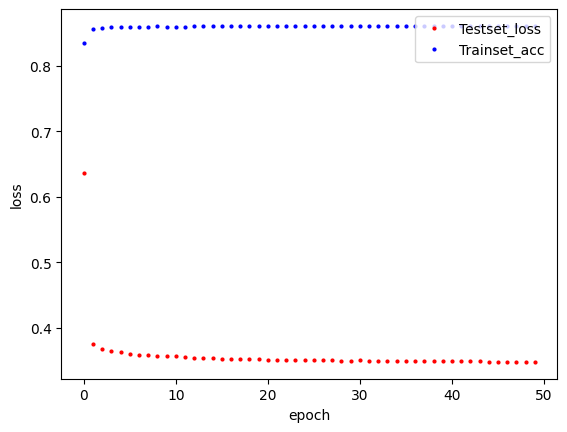

In [31]:
hist_df = pd.DataFrame(history.history)
hist_df

# 오차
y_vloss = hist_df['loss']
# 정확도
y_acc = hist_df['accuracy']

# 오차 -> 빨간색, 정확도-> 파란색
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label="Testset_loss")
plt.plot(x_len, y_acc, "o", c="blue", markersize=2, label="Trainset_acc")

plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [35]:
# 예측
predict = model.predict([[585. ,  586.  ,   1. ,    1.32 ,  1.31 ,  1.22 ,252.5 ,   2.67]])
print(predict)

1/1 [==============================] - 0s 36ms/step
[[1.]]


In [37]:
predict = model.predict([[585. ,  586.  ,   1. ,    1.32 ,  1.31 ,  1.22 ,252.5 ,   2.67], [585. ,  586.  ,   1. ,    5 ,  5 ,  1.22 ,100 ,   5]])
print(predict)

1/1 [==============================] - 0s 42ms/step
[[1.]
 [1.]]
